In [17]:
import pandas as pd
import json
import os
import numpy as np
import pickle
import json
import scipy
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# ========== FUNCTION ==============

In [18]:
# prepare input for AEs, 
# input is combined list of all intersections (vector -> [fpds + hourofday+ weekofday + intersectoion]) for each week and each hour sorted based on time
# output is -> list of feature vector and time for all interctions combined --> [[fpds + hourofday+ weekofday + intersectoion], time]
def prepare_input_for_AEs(featured_fpds):
    combined_fpds_for_AEs = []
    for intersection in featured_fpds.keys():
        for i in range(7):
            for j in range(24):
                for l,m in zip(featured_fpds['K502'][i][j][0],featured_fpds['K502'][i][j][1]):
                    combined_fpds_for_AEs.append([l.astype(np.float32),m])

    combined_fpds_for_AEs = sorted(combined_fpds_for_AEs, key=lambda x:x[1])
    return np.array(combined_fpds_for_AEs)

In [19]:
# function to load data from pickle file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [20]:
class AutoEncoderDataset(Dataset):
    def __init__(self, data):
        self.data = data[:,0]
        self.timesteps = data[:,1]
        self.dim = self.data[0].shape[0]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
import torch.nn as nn
class AE(nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        self.dec = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, input_shape),
            nn.ReLU()
        )
    def forward(self, x):
        encode = self.enc(x)
        decode = self.dec(encode)
        return decode

# =========== MAIN ===========

In [22]:
# load data from pickle file
direction = "North"
trajectory = "T1"
load_fpds_path = f"../data/hauge/processed/featured_fpds_{direction}_{trajectory}.pickle"
featured_fpds = load_pickle(load_fpds_path)

In [23]:
# prepare input for AEs
combined_fpds_for_AEs = prepare_input_for_AEs(featured_fpds)

IndexError: list index out of range

In [24]:
AE_dataset = AutoEncoderDataset(combined_fpds_for_AEs)

In [10]:
train_dataloader = DataLoader(AE_dataset, batch_size=1, shuffle=False)

In [11]:
# define model parameters
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
epochs = 1
metrics = defaultdict(list)
outlier_loss = []
outlier_results = []
device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [12]:
model = AE(AE_dataset.dim)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [13]:
# train model
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, data in enumerate(train_dataloader):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample) # calculate loss for input and recreated output
        outlier_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss/AE_dataset.__len__()
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 1/1
[LOSS] 0.03640773285104627
Epoch Complete in 0:21:37.254258
-----------------------------------------------
[System Complete: 0:21:37.255178]


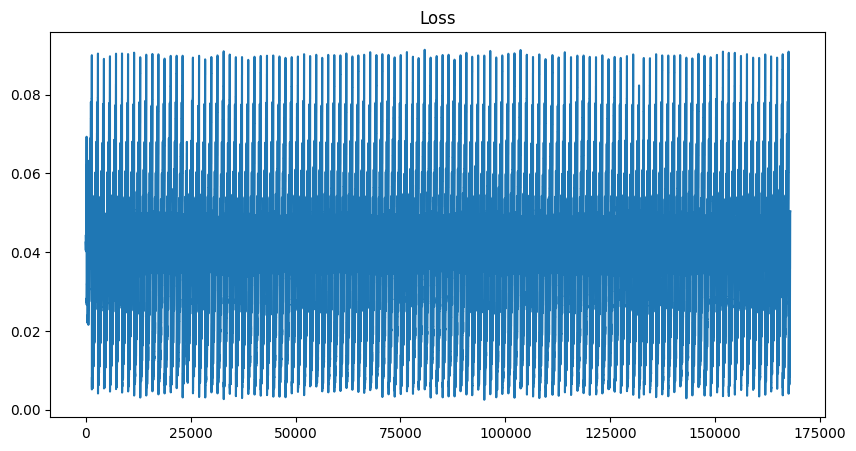

In [14]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(outlier_loss)

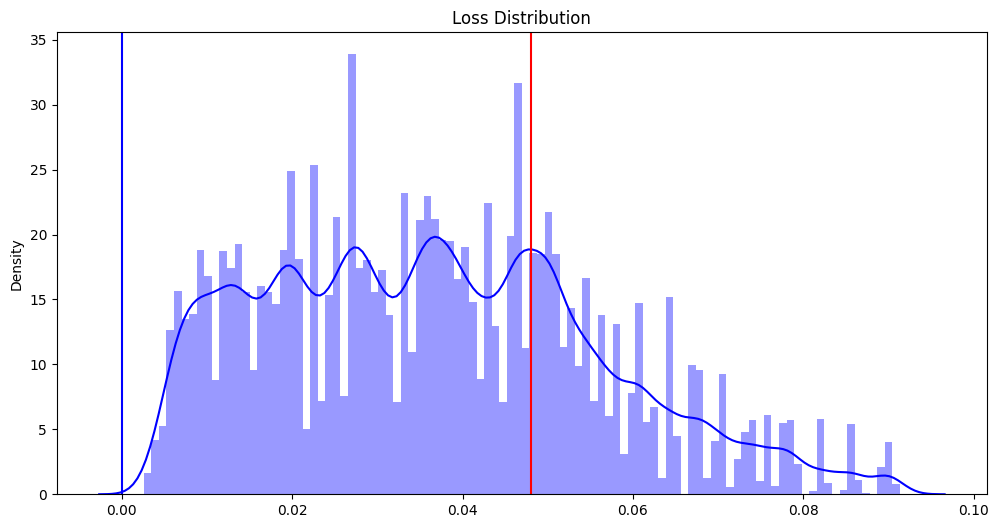

In [15]:
lower_threshold = 0.0
upper_threshold = 0.048
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(outlier_loss,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

<Axes: >

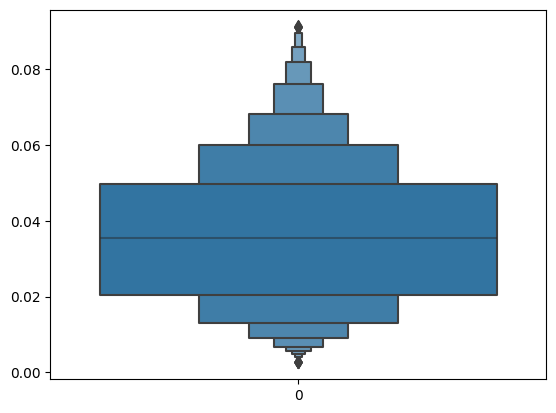

In [16]:
sns.boxenplot(outlier_loss)

In [ ]:


# todo: integrate directions in feature vector, north/south (e.g. one hot encode direction)
# todo: 5. Apply AEs and extract oultiers



# 4. prepare input for AEs
combined_fpds_for_AEs = prepare_input_for_AEs(featured_fpds)
#todo: 6. find correlations between intersection using outlier 


#todo: 7. save results for both trajectories and directions 